In [1]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/train.csv
./data/sample_submission.csv


In [2]:
import pandas as pd
import plotly.express as px
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Plotting
#import matplotlib.pyplot as plt

# %matplotlib inline

In [5]:
test = pd.read_csv("./data/test.csv")
train = pd.read_csv("./data/train.csv")
sub =  pd.read_csv("./data/sample_submission.csv")

In [6]:
rm = test.pop("id")
rm = train.pop("id")

In [7]:
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,A,I,A,B,B,BI,A,S,Q,A,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [8]:
# no missing
# missing_val_count_by_column = (train.isnull().sum())
# print(missing_val_count_by_column[missing_val_count_by_column > 0])
print(train.info(verbose = True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

##--------------------------------------------

In [9]:
# target = train["target"]
# cate_name = train.select_dtypes(['object','category']).columns.to_list()
cont_name = train.drop(['target'], axis = 1).select_dtypes(['float64','int']).columns.to_list()

---

## pre modeling data visualization

In [10]:
# visualization!
def PlotMultiplePie(df,categorical_features = None,dropna = False):
    # set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts
    threshold = 30
    # if user did not set categorical_features
    if categorical_features == None:
        categorical_features = df.select_dtypes(['object','category']).columns.to_list()
    print("The Categorical Features are:",categorical_features)
    # loop through the list of categorical_features
    for cat_feature in categorical_features:
        num_unique = df[cat_feature].nunique(dropna = dropna)
        num_missing = df[cat_feature].isna().sum()
        # prints pie chart and info if unique values below threshold
        if num_unique <= threshold:
            print('Pie Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            # fig = px.pie(df[cat_feature].value_counts(dropna = dropna), values=cat_feature,
            #      names = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
            # fig.show()
        else:
            print('Pie Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')

In [11]:
# PlotMultiplePie(train)

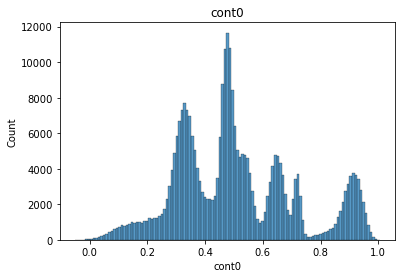

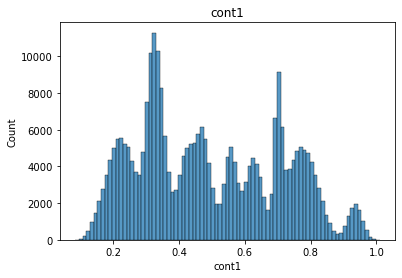

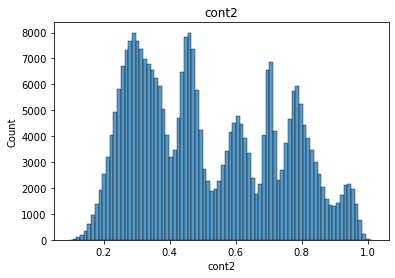

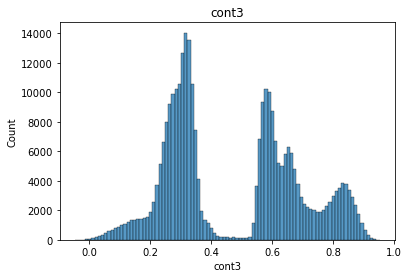

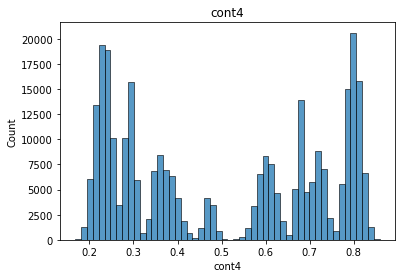

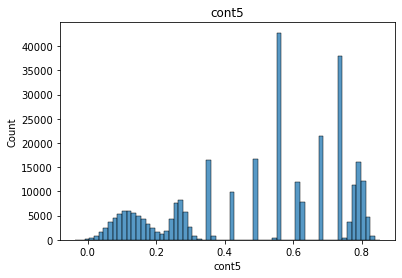

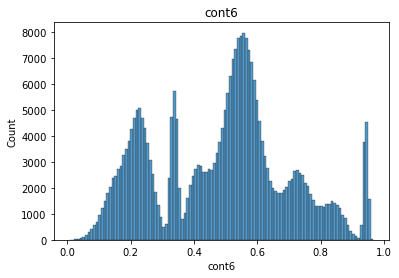

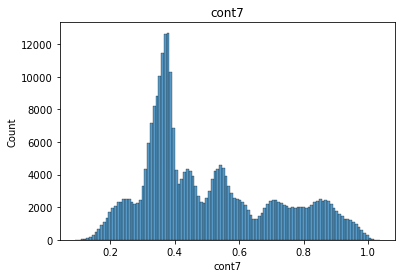

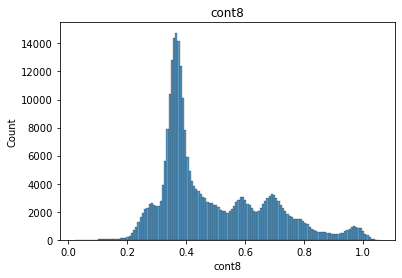

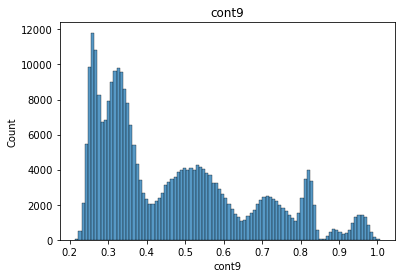

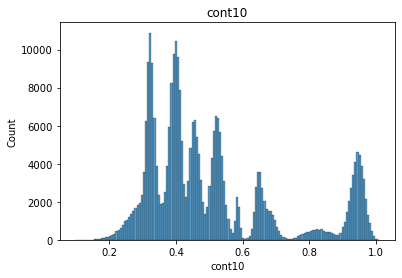

In [12]:
# continuous variables:
#--------------------------------------------
# for cont_feature in cont_name:
#     plt.figure()
#     plt.title(cont_feature)
#     ax = sns.histplot(train[cont_feature])

In [16]:
# dependent Variable.

# plt.figure()
# plt.title("target")
# ax = sns.histplot(train["target"])
# px.histogram(train["target"])

---
## tensorflow


In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include = np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include = object)),
)

In [14]:
y = train.pop('target')
X = train

In [15]:
artists = X['cat10']

In [16]:
# 2 label encoder
from sklearn.preprocessing import LabelEncoder
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(train[c].values)
        test[c] = lbl.transform(test[c].values)

In [17]:
test.to_csv("./encoded_test.csv", index = False)
train.to_csv("./encoded_train.csv", index = False)
y.to_csv("./trian_y.csv", index = False)

In [18]:
os.getcwd()

'/Users/fyenne/Downloads/booooks/semester5/tf24/mar_kaggle'

In [ ]:
#  GroupShuffleSplit
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, valid = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[valid], y.iloc[train], y.iloc[valid])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [16]:
# def loo_encode(train_df, test_df, column):
#     loo = LeaveOneOutEncoder()
#     new_feature = "{}_loo".format(column)
#     loo.fit(train_df[column], train_df["target"])
#     train_df[new_feature] = loo.transform(train_df[column])
#     test_df[new_feature] = loo.transform(test_df[column])
#     return new_feature
input_shape = [X_train.shape[1]]

In [15]:
# X_train = preprocessor.fit_transform(X_train)
# X_valid = preprocessor.transform(X_valid)

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# import kerastuner as kt

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [18]:
def model_builder(hp):
    model = keras.Sequential()
  # model.add(keras.layers.Flatten(input_shape=(28, 28)))
    layers.Dense(2048, activation='sigmoid', input_shape=input_shape),
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units  = hp.Int('units', min_value=992, max_value=1024, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='sigmoid'))
    model.add(keras.layers.Dropout(0.3)),
    model.add(keras.layers.BatchNormalization()),

    # hp_units2 = hp.Int('units', min_value=64 , max_value=1024, step=64)
    model.add(keras.layers.Dense(units=1024, activation='sigmoid'))
    model.add(keras.layers.Dropout(0.3)),
    model.add(keras.layers.BatchNormalization()),

    model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 0.15, 0.1, 0.2])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanAbsoluteError(),
                metrics=['MeanAbsoluteError'])
# tf.keras.losses.MeanAbsoluteError
    return model

In [19]:
import kerastuner as kt

ModuleNotFoundError: No module named 'kerastuner'

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=30,
                     factor=4,
                     directory='my_dir',
                     project_name='intro_to_kt')

Python 3.8.6


In [19]:
# !pip install kerastuner

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
ERROR: Could not find a version that satisfies the requirement kerastuner
ERROR: No matching distribution found for kerastuner


In [20]:
import tensorflow

In [21]:
tensorflow.__version__

'2.4.0-rc0'

In [5]:
import random
def foo(n):
    random.seed()
    c1 = 0
    c2 = 0
    for i in range(n):
        x = random.random()
        y = random.random()
        r1 = x * x + y * y
        r2 = (1 - x) * (1 - x) + (1 - y) * (1 - y)
        if r1 <= 1 and r2 <= 1:
           c1 += 1
        else:
           c2 += 1
    return   c1 / c2

In [8]:
foo(16743453)

1.3292309391625734

In [21]:
zz = list(input().strip().split(' '))

a = max(zz)

In [38]:
zz.index(zz == a)

ValueError: False is not in list